# Generate Unloaded Shape

Using heuristic we found on UKB RAP for generating unloaded volumes from LV EDV, apply it to local statistical shape data that we have from Alistair's group. Then, generate an approximate unloaded shape by changing PCs.

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# import subsample
virtual_data = pd.read_excel("Data/virtual_cohort_data.xlsx")
virtual_data

## Generate Unloaded Volumes

In [ ]:
# linear equation found from applying the Garg et al. equation to UKB data
virtual_data["Unloaded Volume"] = 0.5025 * virtual_data["LV_EDV"] + 5.7574

In [ ]:
# plot a histogram to check distribution of unloaded volumes
plt.hist(virtual_data["Unloaded Volume"], bins=50)
plt.xlabel("Unloaded Volumes")
plt.ylabel("Counts")
plt.show

In [ ]:
virtual_data["Unloaded Volume"].describe()

In [ ]:
# save updated dataframe to a csv
virtual_data.to_excel('Data/virtual_cohort_data.xlsx', index=False)

## Calculate Volumes from PC meshes

In [ ]:
pc_columns = [col for col in virtual_data.columns if col.startswith('PC')]
pc_scores = virtual_data[pc_columns]

pc_scores

In [ ]:
# imports needed to find volumes from meshes
import sys
import scipy.io

sys.path.append("biv-me-main/src")

from bivme.fitting.BiventricularModel import BiventricularModel
import pyvista as pv
from bivme import MODEL_RESOURCE_DIR
from bivme.meshing.mesh import Mesh
from scipy.optimize import minimize

In [ ]:
biv_model_folder = MODEL_RESOURCE_DIR

def find_volume(bivvertices, precision = 1) -> None:
    """
        # Authors: ldt, cm
        # Date: 09/22, revised 08/24 by cm
S
        This function measures the mass and volume of LV and RV.
        #--------------------------------------------------------------
        Inputs: model_file = fitted model (.txt), containing only data relative to one frame
                output_file = path to the output csv file
                biv_model_folder = path to the model folder - default: MODEL_RESOURCE_DIR
                precision - output precision for the volumes
        Output: None
    """
    # assign values to dict
    results_dict = {
        k: '' for k in ['lv_vol', 'rv_vol', 'lv_epivol', 'rv_epivol', 'lv_mass', 'rv_mass']
    }

    subdivision_matrix_file = biv_model_folder / "subdivision_matrix_sparse.mat"
    assert subdivision_matrix_file.exists(), \
        f"biv_model_folder does not exist. Cannot find {subdivision_matrix_file} file!"

    elements_file = biv_model_folder / 'ETIndicesSorted.txt'
    assert elements_file.exists(), \
        f"biv_model_folder does not exist. Cannot find {elements_file} file!"

    material_file = biv_model_folder / 'ETIndicesMaterials.txt'
    assert material_file.exists(), \
        f"biv_model_folder does not exist. Cannot find {material_file} file!"

    thru_wall_file = biv_model_folder / 'thru_wall_et_indices.txt'
    assert thru_wall_file.exists(), \
        f"biv_model_folder does not exist. Cannot find {thru_wall_file} file!"
    
    control_points = bivvertices

    if control_points.shape[0] > 0:
        subdivision_matrix = scipy.io.loadmat(subdivision_matrix_file)['S'].toarray()
        faces = np.loadtxt(elements_file).astype(int)-1
        mat = np.loadtxt(material_file, dtype='str')

        # A.M. :there is a gap between septum surface and the epicardial
        #   Which needs to be closed if the RV/LV epicardial volume is needed
        #   this gap can be closed by using the et_thru_wall facets
        et_thru_wall = np.loadtxt(thru_wall_file, delimiter='\t').astype(int)-1

        ## convert labels to integer corresponding to the sorted list
        # of unique labels types
        unique_material = np.unique(mat[:,1])

        materials = np.zeros(mat.shape)
        for index, m in enumerate(unique_material):
            face_index = mat[:, 1] == m
            materials[face_index, 0] = mat[face_index, 0].astype(int)
            materials[face_index, 1] = [index] * np.sum(face_index)

        # add material for the new facets
        new_elem_mat = [list(range(materials.shape[0], materials.shape[0] + et_thru_wall.shape[0])),
                        [len(unique_material)] * len(et_thru_wall)]

        vertices = control_points
        faces = np.concatenate((faces.astype(int), et_thru_wall))
        materials = np.concatenate((materials.T, new_elem_mat), axis=1).T.astype(int)

        model = Mesh('mesh')
        model.set_nodes(vertices)
        model.set_elements(faces)
        model.set_materials(materials[:, 0], materials[:, 1])

        # components list, used to get the correct mesh components:
        # ['0 AORTA_VALVE' '1 AORTA_VALVE_CUT' '2 LV_ENDOCARDIAL' '3 LV_EPICARDIAL'
        # ' 4 MITRAL_VALVE' '5 MITRAL_VALVE_CUT' '6 PULMONARY_VALVE' '7 PULMONARY_VALVE_CUT'
        # '8 RV_EPICARDIAL' '9 RV_FREEWALL' '10 RV_SEPTUM' '11 TRICUSPID_VALVE'
        # '12 TRICUSPID_VALVE_CUT', '13' THRU WALL]

        lv_endo = model.get_mesh_component([0, 2, 4], reindex_nodes=False)

        # Select RV endocardial
        rv_endo = model.get_mesh_component([6, 9, 10, 11], reindex_nodes=False)

        # switching the normal direction for the septum
        rv_endo.elements[rv_endo.materials == 10, :] = \
            np.array([rv_endo.elements[rv_endo.materials == 10, 0],
                      rv_endo.elements[rv_endo.materials == 10, 2],
                      rv_endo.elements[rv_endo.materials == 10, 1]]).T

        lv_epi = model.get_mesh_component([0, 1, 3, 4, 5, 10, 13], reindex_nodes=False)
        # switching the normal direction for the thru wall
        lv_epi.elements[lv_epi.materials == 13, :] = \
            np.array([lv_epi.elements[lv_epi.materials == 13, 0],
                      lv_epi.elements[lv_epi.materials == 13, 2],
                      lv_epi.elements[lv_epi.materials == 13, 1]]).T

        # switching the normal direction for the septum
        rv_epi = model.get_mesh_component([6, 7, 8, 10, 11, 12, 13], reindex_nodes=False)
        rv_epi.elements[rv_epi.materials == 10, :] = \
            np.array([rv_epi.elements[rv_epi.materials == 10, 0],
                      rv_epi.elements[rv_epi.materials == 10, 2],
                      rv_epi.elements[rv_epi.materials == 10, 1]]).T

        lv_endo_vol = lv_endo.get_volume()
        rv_endo_vol = rv_endo.get_volume()
        lv_epi_vol = lv_epi.get_volume()
        rv_epi_vol = rv_epi.get_volume()

        rv_mass = (rv_epi_vol - rv_endo_vol) * 1.05  # mass in grams
        lv_mass = (lv_epi_vol - lv_endo_vol) * 1.05

        # assign values to dict
        results_dict['lv_vol'] = round(lv_endo_vol, precision)
        results_dict['rv_vol'] = round(rv_endo_vol, precision)
        results_dict['lv_epivol'] = round(lv_epi_vol, precision)
        results_dict['rv_epivol'] = round(rv_epi_vol, precision)
        results_dict['lv_mass'] = round(lv_mass, precision)
        results_dict['rv_mass'] = round(rv_mass, precision)

    return results_dict

# reconstructs shape given PC scores
def reconstruct_shape(score, atlas):
    d = score * np.sqrt(atlas["LATENT"][0:25]).T
    shape = atlas["MU"] + np.matmul(d, atlas["COEFF"][:, :25].T)
    return shape.T

# Extract ED phase as (N, 3) mesh
def get_ED_mesh_from_shape(shape):
    N = len(shape)
    return shape[:N // 2].reshape(-1, 3)

In [ ]:
# Load PCA model from .mat file
mat_data = scipy.io.loadmat("Data/BioBank_EDES_200.mat")
pca = mat_data['pca200'][0, 0]

In [ ]:
# test calculating volumes
i = 0
z_subject = list(pc_scores.loc[i,:])
test_shape = reconstruct_shape(z_subject, pca)
ed_shape = get_ED_mesh_from_shape(test_shape)
test = find_volume(ed_shape)

target_volume = virtual_data["Unloaded Volume"].iloc[i]
target_mass = test["lv_mass"]

print(f"Target LV Volume: {target_volume:.2f} mL")
print(f"Original LV Mass:    {target_mass:.2f} g\n")

# store test which is a dictionary as a dataframe
df = pd.DataFrame([test])
print(df)

## Generate unloaded volumes

Use scipy.optimize.minimize to optimize the PC scores s such that the volume of the reconstructed shape S(s) closely matches the known unloaded volume V_target (while keeping the masses relatively the same). 

There are two different functions defined here: the first one optimizes mass as well but honestly it doesn't work out too well. The second function only optimizes based off the volume. The shape is not going to be as biologically meaninful but the optimization works quickly.

In [ ]:
def find_unloaded_pcs_by_gradient_descent(
    initial_pc_scores: np.ndarray,
    target_volume: float,
    original_lv_mass: float,         
    reconstruct_shape: callable,
    get_ED_mesh_from_shape: callable,
    find_volume: callable,
    learning_rate: float = 0.01,
    max_iterations: int = 200,
    tolerance: float = 0.1,
    epsilon: float = 1e-4,
    mass_constraint_weight: float = 0.5 
) -> tuple:
    print("Starting optimization process with mass constraint...\n")
    pc_scores = np.copy(initial_pc_scores)
    num_pcs = len(pc_scores)
    volume_history = []
    mass_history = []

    for i in range(max_iterations):
        # Calculate the current volume, mass, and errors
        current_mesh = reconstruct_shape(pc_scores, pca)
        ed_mesh = get_ED_mesh_from_shape(current_mesh)
        
        current_properties = find_volume(ed_mesh)
        current_volume = current_properties['lv_vol']
        current_mass = current_properties['lv_mass']

        volume_history.append(current_volume)
        mass_history.append(current_mass)

        volume_error = current_volume - target_volume
        mass_error = current_mass - original_lv_mass
        
        # calculate a single "loss" value that combines both errors.
        # We use the sum of squared errors. Our goal is to make this loss zero.
        loss = (volume_error**2) + mass_constraint_weight * (mass_error**2)

        print(
            f"Iter {i+1:03d}: "
            f"Volume = {current_volume:6.2f} (Err: {volume_error:6.2f}), "
            f"Mass = {current_mass:5.2f} (Err: {mass_error:5.2f}), "
            f"Loss = {loss:.4f}"
        )

        # Check for convergence based on volume error
        if abs(volume_error) < tolerance:
            print(f"\nConvergence achieved! Volume error is within the tolerance of {tolerance} mL.")
            break

        # Calculate the gradient of the COMBINED LOSS with respect to each PC score
        gradient = np.zeros(num_pcs)
        for j in range(num_pcs):
            pc_scores_perturbed = np.copy(pc_scores)
            pc_scores_perturbed[j] += epsilon

            mesh_perturbed = reconstruct_shape(pc_scores_perturbed, pca)
            ed_perturbed = get_ED_mesh_from_shape(mesh_perturbed)
            
            properties_perturbed = find_volume(ed_perturbed)
            
            # Calculate the loss of the perturbed mesh
            volume_error_p = properties_perturbed['lv_vol'] - target_volume
            mass_error_p = properties_perturbed['lv_mass'] - original_lv_mass
            loss_perturbed = (volume_error_p**2) + mass_constraint_weight * (mass_error_p**2)
            
            # Approximate the partial derivative of the combined loss function
            partial_derivative = (loss_perturbed - loss) / epsilon
            gradient[j] = partial_derivative
        
        # Normalize the gradient to prevent excessively large steps
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > 0:
            gradient /= gradient_norm

        # Update the PC scores
        pc_scores -= learning_rate * gradient

    else:
        print(f"\nOptimization finished after {max_iterations} iterations without reaching the exact tolerance.")

    print(f"\nFinal optimized PC scores: {np.round(pc_scores, 4)}")
    print(f"\n Difference in z-scores: {np.round(pc_scores - initial_pc_scores, 4)}")
    return pc_scores, volume_history, mass_history

In [26]:
# Find the PC scores that correspond to the unloaded volume
unloaded_pc_scores, volume_history, mass_history = find_unloaded_pcs_by_gradient_descent(
    initial_pc_scores=z_subject,
    target_volume=target_volume,
    original_lv_mass=target_mass,
    reconstruct_shape=reconstruct_shape,
    get_ED_mesh_from_shape=get_ED_mesh_from_shape,
    find_volume=find_volume,
    learning_rate=0.05,
    max_iterations=200,
    tolerance=1,
    epsilon=0.5,
    mass_constraint_weight=0.1  # tune this parameter, higher values put more emphasis on mass constraint (higher values will converge slower)
)

Iter 004: Volume = 118.00 (Err:  50.79), Mass = 78.30 (Err: -2.80), Loss = 2580.0881
Iter 005: Volume = 116.60 (Err:  49.39), Mass = 77.40 (Err: -3.70), Loss = 2440.4300
Iter 006: Volume = 115.20 (Err:  47.99), Mass = 76.50 (Err: -4.60), Loss = 2304.8538
Iter 007: Volume = 113.80 (Err:  46.59), Mass = 75.60 (Err: -5.50), Loss = 2173.3596
Iter 008: Volume = 112.40 (Err:  45.19), Mass = 74.80 (Err: -6.30), Loss = 2045.8204
Iter 009: Volume = 111.10 (Err:  43.89), Mass = 73.90 (Err: -7.20), Loss = 1931.2396
Iter 010: Volume = 109.70 (Err:  42.49), Mass = 73.00 (Err: -8.10), Loss = 1811.6934
Iter 011: Volume = 108.40 (Err:  41.19), Mass = 72.20 (Err: -8.90), Loss = 1704.2776
Iter 012: Volume = 107.10 (Err:  39.89), Mass = 71.30 (Err: -9.80), Loss = 1600.5648
Iter 013: Volume = 105.80 (Err:  38.59), Mass = 70.50 (Err: -10.60), Loss = 1500.1810
Iter 014: Volume = 104.50 (Err:  37.29), Mass = 69.60 (Err: -11.50), Loss = 1403.5342
Iter 015: Volume = 103.20 (Err:  35.99), Mass = 68.80 (Err: -12

In [27]:
# Reconstruct the mesh with optimized scores
optimized_shape = reconstruct_shape(unloaded_pc_scores, pca)
optimized_ed_shape = get_ED_mesh_from_shape(optimized_shape)

# Compute volumes with the optimized mesh
optimized_volumes = find_volume(optimized_ed_shape)
df_optimized = pd.DataFrame([optimized_volumes])
print("\nOptimized Volumes:")
print(df_optimized)


Optimized Volumes:
   lv_vol  rv_vol  lv_epivol  rv_epivol  lv_mass  rv_mass
0    67.5    66.8      111.2       88.9     45.9     23.2


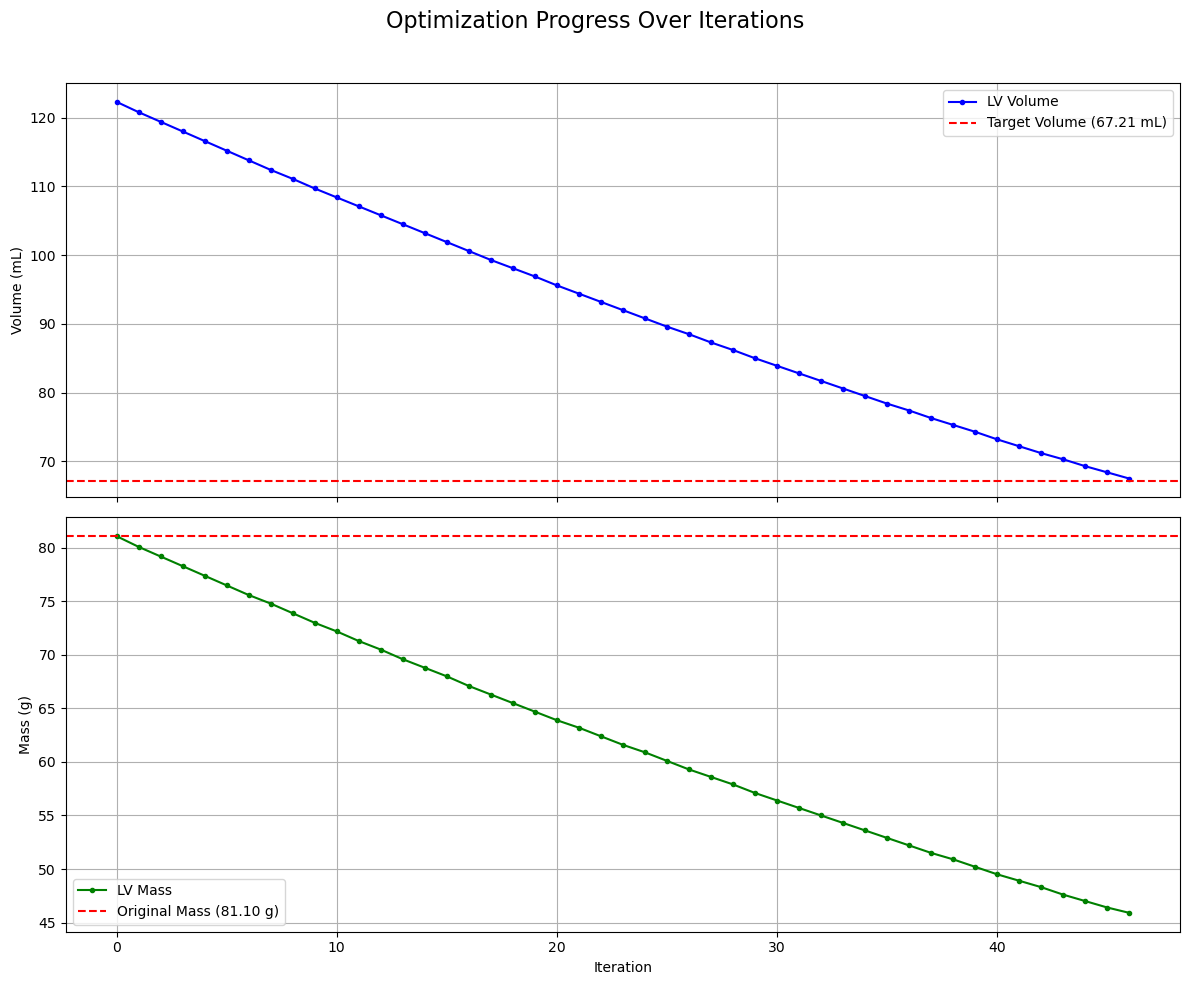

Plot displayed.


In [28]:
#print optimization results over time
import matplotlib.pyplot as plt

# Create a figure with two subplots, sharing the same x-axis (Iteration)
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 10),
    sharex=True
)
fig.suptitle('Optimization Progress Over Iterations', fontsize=16)

# volume history
ax1.plot(volume_history, marker='.', linestyle='-', color='b', label='LV Volume')
# Add a horizontal line for the target volume
ax1.axhline(y=target_volume, color='r', linestyle='--', label=f'Target Volume ({target_volume:.2f} mL)')
ax1.set_ylabel('Volume (mL)')
ax1.legend()
ax1.grid(True)

# mass history
ax2.plot(mass_history, marker='.', linestyle='-', color='g', label='LV Mass')
# Add a horizontal line for the original mass
ax2.axhline(y=target_mass, color='r', linestyle='--', label=f'Original Mass ({target_mass:.2f} g)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Mass (g)')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

print("Plot displayed.")

### Visualize Shape

In [29]:
# visualize shape from the z-scores
import numpy as np
import pyvista as pv
# pv.set_jupyter_backend('panel')  # or 'panel' as fallback

# Surface region index ranges
SurfaceStartEnd = [
    (0, 3072),     # LV
    (3072, 4480),  # RVS
    (4480, 6752),  # RVFW
    (6752, 11616), # Epi
    (11616, 11664),# Mitral
    (11664, 11688),# Aortic
    (11688, 11728),# Tricuspid
    (11728, 11760) # Pulmonary
]

def build_pv_mesh(vertices, faces):
    # Convert to pyvista face format: [3, i0, i1, i2] per triangle
    n_faces = faces.shape[0]
    face_data = np.hstack([np.full((n_faces, 1), 3), faces]).astype(np.int32)
    return pv.PolyData(vertices, face_data)

def plot_ed_shape_pyvista(vertices, et_indices, show_valves=True):
    # Segment faces
    LV_faces = et_indices[SurfaceStartEnd[0][0]:SurfaceStartEnd[0][1]]
    RV_faces = et_indices[SurfaceStartEnd[1][0]:SurfaceStartEnd[2][1]]
    EPI_faces = et_indices[SurfaceStartEnd[3][0]:SurfaceStartEnd[3][1]]

    LV_mesh = build_pv_mesh(vertices, LV_faces)
    RV_mesh = build_pv_mesh(vertices, RV_faces)
    EPI_mesh = build_pv_mesh(vertices, EPI_faces)

    plotter = pv.Plotter(notebook=True)
    plotter.set_background("white")

    # Add surfaces
    plotter.add_mesh(LV_mesh, color=(0, 0.5, 0), show_edges=False, smooth_shading=True, opacity=1.0, name="LV")
    plotter.add_mesh(RV_mesh, color=(0, 0, 0.8), show_edges=False, smooth_shading=True, opacity=1.0, name="RV")
    plotter.add_mesh(EPI_mesh, color=(0.5, 0, 0), show_edges=False, smooth_shading=True, opacity=0.5, name="Epi")

    if show_valves:
        _add_valves_to_plotter(plotter, vertices, et_indices)

    plotter.view_vector((1, 1, 0.5), viewup=(0, 0, 1))
    return plotter.show()

def _add_valves_to_plotter(plotter, vertices, et_indices):
    def valve_lines(start, end, color):
        faces = et_indices[start:end]
        for i in range(0, len(faces), 2):
            try:
                v1 = vertices[faces[i, [0, 2]]]
                v2 = vertices[faces[i + 1, [0, 1]]]
                points = np.vstack([v1, v2])
                line = pv.lines_from_points(points)
                plotter.add_mesh(line, color=color, line_width=2)
            except IndexError:
                continue

    valve_lines(*SurfaceStartEnd[4], 'cyan')     # Mitral
    valve_lines(*SurfaceStartEnd[5], 'yellow')   # Aortic
    valve_lines(*SurfaceStartEnd[6], 'magenta')  # Tricuspid
    valve_lines(*SurfaceStartEnd[7], 'green')    # Pulmonary

In [30]:
# Suppose you have an ED model from PCA or shape model:
et_indices = np.loadtxt("biv-me-main/src/model/ETIndicesSorted.txt").astype(int) - 1

plot_ed_shape_pyvista(optimized_ed_shape, et_indices)

Widget(value='<iframe src="http://localhost:60720/index.html?ui=P_0x182f583b9b0_0&reconnect=auto" class="pyvis…

## Just Volume
If I just wanted to reconstruct the biv unloaded shape by matching the LV volumes

In [ ]:
import numpy as np
import time

def find_unloaded_pcs_by_gradient_descent(
    initial_pc_scores: np.ndarray,
    target_volume: float,
    reconstruct_shape: callable,
    get_ED_mesh_from_shape: callable,
    find_volume: callable,
    learning_rate: float = 0.01,
    max_iterations: int = 200,
    tolerance: float = 0.1,
    epsilon: float = 1e-4
    ) -> np.ndarray:

    """
    Finds the PC scores that produce a target volume using gradient descent.
    Args:
        initial_pc_scores (np.ndarray): The starting PC scores (e.g., for the ED shape).
        target_volume (float): The desired unloaded volume (e.g., in mL).
        reconstruct_mesh_func (callable): Your function to build a mesh from PC scores.
        calculate_volume_func (callable): Your function to find the volume of a mesh.
        learning_rate (float): Step size for each iteration. May need tuning.
        max_iterations (int): Maximum number of iterations to prevent infinite loops.
        tolerance (float): The acceptable volume difference to stop optimization.
        epsilon (float): A small value used for numerically calculating the gradient.

    Returns:
        np.ndarray: The optimized PC scores for the unloaded shape.
    """
    print("Starting optimization process...\n")
    pc_scores = np.copy(initial_pc_scores)
    num_pcs = len(pc_scores)

    for i in range(max_iterations):
        # 1. Calculate the current volume and error
        current_mesh = reconstruct_shape(pc_scores, pca)
        ed_mesh = get_ED_mesh_from_shape(current_mesh)
        current_volume = find_volume(ed_mesh)['lv_vol']
        error = current_volume - target_volume
        print(f"Iteration {i+1:03d}: Current Volume = {current_volume:7.2f} mL, Target = {target_volume:7.2f} mL, Error = {error:7.2f} mL")

        # 2. Check for convergence
        if abs(error) < tolerance:
            print(f"\nConvergence achieved! Final volume is within the tolerance of {tolerance} mL.")
            break

        # 3. Calculate the gradient of the volume with respect to each PC score
        # This tells us how a small change in each PC affects the volume
        gradient = np.zeros(num_pcs)
        for j in range(num_pcs):
            # Perturb the j-th PC score by a small amount (epsilon)
            pc_scores_perturbed = np.copy(pc_scores)
            pc_scores_perturbed[j] += epsilon
            # Calculate the volume of the perturbed mesh
            mesh_perturbed = reconstruct_shape(pc_scores_perturbed, pca)
            ed_perturbed = get_ED_mesh_from_shape(mesh_perturbed)
            volume_perturbed = find_volume(ed_perturbed, label=name)

            # # Approximate the partial derivative (how much the volume changed)
            partial_derivative = (volume_perturbed['lv_vol'] - current_volume) / epsilon
            gradient[j] = partial_derivative

        # Normalize the gradient to prevent excessively large steps
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > 0:
            gradient /= gradient_norm

        # 4. Update the PC scores
        # We move the scores "downhill" along the gradient to reduce the error.
        # The step size is proportional to the learning rate and the error itself.
        update_step = learning_rate * error * gradient
        pc_scores -= update_step

    else:
        # This block executes if the for loop finishes without a 'break'
        print(f"\nOptimization finished after {max_iterations} iterations without reaching the exact tolerance.")

    print(f"\nFinal optimized PC scores: {np.round(pc_scores, 4)}")
    return pc_scores

# EXAMPLE USAGE 

# --- Configuration ---
# --- Run the Optimization ---
# Calculate initial volume for context
print("--- Initial State ---")
print(f"Initial PC Scores: {z_subject}")
print(f"Initial (ED) Volume: {target_volume:.2f} mL\n")

start_time = time.time()

# Find the PC scores that correspond to the unloaded volume
unloaded_pc_scores = find_unloaded_pcs_by_gradient_descent(
    initial_pc_scores=z_subject,
    target_volume=target_volume,
    reconstruct_shape=reconstruct_shape,
    get_ED_mesh_from_shape=get_ED_mesh_from_shape,
    find_volume=find_volume,
    learning_rate=0.05, # You might need to tune this
    max_iterations=200,
    tolerance=0.1, # And this (e.g., 0.1 mL is very precise)
    epsilon=0.5
)

end_time = time.time()

# --- Verification ---
print("\n--- Final State ---")
print(f"Optimization took {end_time - start_time:.2f} seconds.")
# Reconstruct the final mesh and verify its volume
final_unloaded_mesh = reconstruct_shape(unloaded_pc_scores, pca)
final_ed_mesh = get_ED_mesh_from_shape(final_unloaded_mesh)
final_volume = find_volume(final_ed_mesh, label=name)

print(f"\n Difference in z-scores: {np.round(unloaded_pc_scores - z_subject, 4)}")

print(f"Final calculated volume: {final_volume['lv_vol']:.2f} mL")
print(f"Target volume: {target_volume:.2f} mL")
print(f"Difference: {abs(final_volume['lv_vol'] - target_volume):.4f} mL")